#### DSFSI Covid19 - Covid Prediction using SIR Model
By: Tinashe Chinyati and Graeme Lubbe

#### Datasets
- covid19za_provincial_cumulative_timeline_confirmed.csv
- covid19za_provincial_cumulative_timeline_recoveries.csv
- covid19za_provincial_cumulative_timeline_deaths.csv

## 1.  Import necessary libraries

In [54]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

### 2. Assumptions

In [52]:
# Between I and R, the transition rate is assumed to be proportional to the number of infectious individuals which is gamma *I
# From infected you dont travel back to susceptible and from recovered you do not travel back to infected.
# Assume a closed population meaning no other people are coming in from other populations. Population is not going to grow
# Recovery population never decrease
# no one has been vaccinated
# no one has had the disease before
# there’s no way to control the spread of the disease

### 3. Import data 

In [55]:
confirmed_cases = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv')
recoveries = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv')

In [58]:
confirmed_cases['Daily Confirmed Cases'] = confirmed_cases['total'] - confirmed_cases['total'].shift(1)

In [62]:
current_cases = confirmed_cases['Daily Confirmed Cases'].iloc[-1]

In [65]:
recoveries['Daily recoveries'] = recoveries['total'] - recoveries['total'].shift(1)

In [67]:
current_recoveries = recoveries['Daily recoveries'].iloc[-1]

### 4. SIR Model

A basic compartmental model of how disease spreads

- Susceptible population: people who could catch the disease
- Infected population: people who have the disease and can spread it
- Recovered/Removed people: people who had the disease and cannot get it again

### 5. Set the parameters of the SIR Model

In [79]:
#Assumed Population: Population for SA was taken from https://www.worldometers.info/world-population/south-africa-population/ 
# as of Saturday, May 7, 2022, based on Worldometer elaboration of the latest United Nations data.
total_population = 60684949

#Number of days to consider
days = 200

#Initial Infected and recovered individuals: Take this from the dsfsi data, these are just constant for developing the model
initial_infected = current_cases   # 100
initial_recovered = current_recoveries  # 0

#parameters to build beta (Transmission rate)
average_num_contacts_per_person = 5  #per day. This is how often do infected and susceptible people come in contact?
prob_of_disease_transimission = 0.04 # during one of those contacts, what is the chance of spreading the disease?

#parameter to build gamma (the avg of days that it takes to get better or pass away) In RSA its set to 10 days
recovery_period_in_days = 10

def get_initial_susceptible(total_population, initial_infected, initial_recovered):
    return total_population - (initial_infected + initial_recovered)

initial_susceptible = get_initial_susceptible(total_population, initial_infected, initial_recovered)

def get_beta(average_num_contacts_per_person, prob_of_disease_transimission):
    return average_num_contacts_per_person * prob_of_disease_transimission

def get_mean_recovery_rate(recovery_period_in_days):
    return 1.0/recovery_period_in_days

#beta is the rate at which people flow from susceptible to infected daily. Infected person infects {beta} people daily
beta = get_beta(average_num_contacts_per_person, prob_of_disease_transimission)

#gamma, avg transmission rate from infectious to recovered
gamma =get_mean_recovery_rate(recovery_period_in_days)

#RO is expected number of secondary cases produced by a single (typical) infection in a completely susceptible population
R0 = beta/gamma

# All of these compartments (susceptible, infected and recovered) change with time and we need to perform 
# calculations for different points in time. 
#Each derivative is a function of time, so we use numpy array for calculations and plotting
time_grid = np.linspace(0, days, days)

#Set initial conditions for the Differential Equation Solver
initial_conditions = (initial_susceptible, initial_infected, initial_recovered)

params_dict = {
    'total_population' : total_population,
    'days': days,
    'initial_infected': initial_infected,
    'initial_recovered': initial_recovered,
    'initial_susceptible': initial_susceptible,
    'average_num_contacts_per_person':average_num_contacts_per_person,
    'prob_of_disease_transimission':prob_of_disease_transimission,
    'beta':beta,
    'gamma':gamma,
    'R0':R0,
    'time_grid':len(time_grid)
}

for k,v in params_dict.items():
    print(f'{k} : {v}')

total_population : 60684949
days : 200
initial_infected : 9253.0
initial_recovered : 5829.0
initial_susceptible : 60669867.0
average_num_contacts_per_person : 5
prob_of_disease_transimission : 0.04
beta : 0.2
gamma : 0.1
R0 : 2.0
time_grid : 200


### 6. Derivatives

In [80]:
def derivative_susceptible_wrt_time(beta,susceptible, infectious, total_population):
    """
    Assumptions: Susceptible will always decrease and assumes immunity
    """
    return -beta * susceptible * (infectious/total_population)

def derivative_infectious_wrt_time(beta, susceptible, infectious, total_population, gamma):
    """Infectious draws from susceptible and is depleted by recovered"""
    return beta * susceptible * (infectious/total_population) - (gamma*infectious)

def derivative_recovery_wrt_time(gamma, infectious):
    """Assume recovered never decreases"""
    return gamma * infectious

def derivatives_helper(initial_conditions, time_grid, total_population, beta, gamma):
    """This facilitates odeint"""
    susceptible, infectious, recovered = initial_conditions
    dSdt = derivative_susceptible_wrt_time(beta,susceptible, infectious, total_population)
    dIdt = derivative_infectious_wrt_time(beta, susceptible, infectious, total_population, gamma)
    dRdt = derivative_recovery_wrt_time(gamma, infectious)
    
    return dSdt, dIdt, dRdt 

###  7. Integrate SIR equations over the time grid

In [81]:
consolidated_functions = odeint(derivatives_helper, initial_conditions, time_grid, args=(total_population, beta, gamma))

In [82]:
# Unpack the consolidated_functions array
susceptible, infectious, recovered = consolidated_functions.T

### 8. Plot SIR Model

In [83]:
def plot_sir_model(time_grid, susceptible, infectious, recovered):
    figure = plt.figure(facecolor='w', figsize=(15,10))
    ax = figure.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    ax.plot(time_grid, susceptible, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(time_grid, infectious, 'r', alpha=0.5, lw=2, label='Infectious')
    ax.plot(time_grid, recovered, 'g', alpha=0.5, lw=2, label='Recovered')
    ax.set_xlabel('Days')
    ax.set_ylabel('Number of People')
    
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    plt.show()

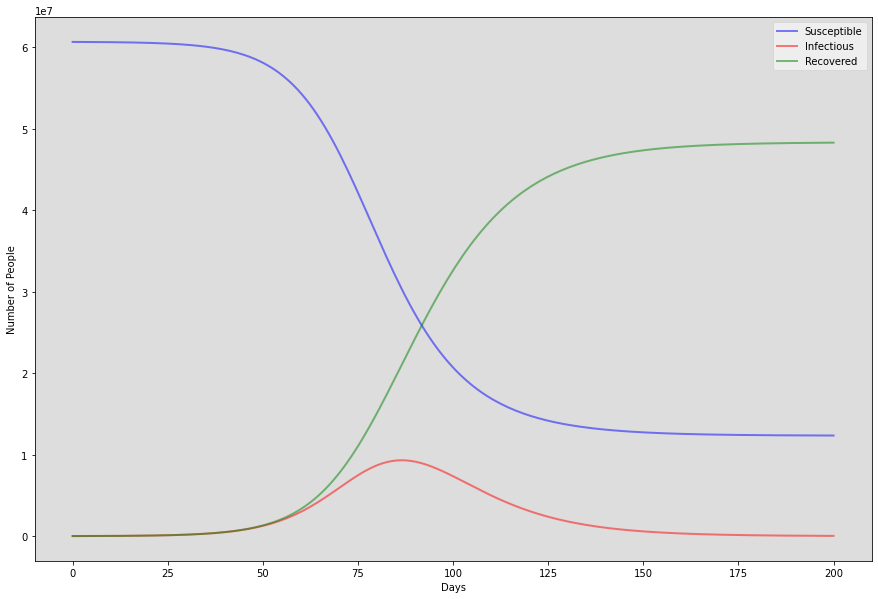

In [84]:
plot_sir_model(time_grid, susceptible, infectious, recovered)